In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import math


import matplotlib.pyplot as plt

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [45]:
# building_id
#columns = X.columns
data_train = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [46]:
data = data_train.append(X_test, ignore_index=True, sort=False)
data = data.drop(['building_id'], axis=1)
print(data.isnull().values.any())

True


In [47]:
# fill the nan values
data.fillna(data.median(), inplace=True)

sale_price = data['total_price'].values
data = data.drop('total_price', axis=1)

columns = data.columns
# check has any nan value in data
data.isnull().values.any()

False

In [49]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

scaling_data = x_scaler.fit_transform(data)
scaling_sale_price = y_scaler.fit_transform(sale_price.reshape(-1, 1))

data = pd.DataFrame(scaling_data, columns = columns)
sale_price = pd.DataFrame(scaling_sale_price, columns=['total_price'])
data.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,0.7,1.000000,0.220133,0.107143,0.75,0.2,0.300577,1.0,0.005952,0.042916,...,0.037838,0.034503,1.0,0.045336,1.0,0.135021,0.0,0.181915,0.0,0.031126
1,0.7,0.222222,0.269487,0.142857,0.25,0.2,0.379486,1.0,0.005952,0.042916,...,0.012613,0.016657,1.0,0.033208,1.0,0.868705,0.0,0.979105,0.0,0.036191
2,0.7,0.222222,0.461026,0.107143,0.25,0.2,0.288697,1.0,0.005952,0.042916,...,0.048649,0.046401,1.0,0.061219,1.0,0.862568,0.0,0.979317,0.0,0.049197
3,0.7,1.000000,0.890325,0.821429,0.00,0.2,0.889899,0.0,0.005952,0.079516,...,0.003604,0.011898,1.0,0.036096,1.0,0.139679,0.0,0.220238,0.0,0.090022
4,0.0,1.000000,0.996866,0.035714,1.00,0.2,0.330351,1.0,0.005952,0.042916,...,0.003604,0.010708,1.0,0.013572,1.0,0.140720,0.0,0.225440,0.0,0.112169


In [51]:
# split data
train_x = data.iloc[:60000]
test_x  = data.iloc[60000:]

train_y = sale_price.iloc[:60000]
test_y = sale_price.iloc[60000:]


In [53]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=42)

In [54]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        self.fc1 = nn.Linear(233, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        '''
        
        self.fc1 = nn.Linear(233, 144)
        self.fc2 = nn.Linear(144, 1)
        
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        '''
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        '''
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
        
## takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: 
            torch.nn.init.zeros_(m.bias)

In [55]:
def batch_training(X_train, y_train):
    train_batch = np.array_split(X_train, 50)
    label_batch = np.array_split(y_train, 50)

    for i in range(len(train_batch)):
        train_batch[i] = torch.from_numpy(train_batch[i].values).float().to(device)
    for i in range(len(label_batch)):
        label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1).to(device)
    return train_batch, label_batch

#train_batch = torch.from_numpy(X_train.values).float().to(device)
#label_batch = torch.from_numpy(y_train).float().view(-1, 1).to(device)
train_batch, label_batch = batch_training(X_train, y_train)

In [56]:
X_val = torch.from_numpy(X_val.values).float().to(device)
y_val = torch.from_numpy(y_val.values).float().view(-1, 1).to(device)

In [57]:
model = Regressor().to(device)
ps = model(train_batch[0])

In [58]:

model = Regressor().to(device)
#model.apply(weights_init)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.003)

epochs = 50000
train_losses, test_losses = [], []

for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        #MSE(output, label_batch[i])
        #loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
                
        train_loss += loss.item()
        
        
    if e%50 == 0:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            #test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
            test_loss += torch.sqrt(criterion(predictions, y_val))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.8f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.8f}.. ".format(test_loss))
        


Epoch: 1/50000..  Training Loss: 0.01461171..  Test Loss: 0.01448576.. 
Epoch: 51/50000..  Training Loss: 0.00007689..  Test Loss: 0.00922441.. 
Epoch: 101/50000..  Training Loss: 0.00005529..  Test Loss: 0.00842781.. 
Epoch: 151/50000..  Training Loss: 0.00001940..  Test Loss: 0.00819568.. 
Epoch: 201/50000..  Training Loss: 0.00001289..  Test Loss: 0.00753177.. 
Epoch: 251/50000..  Training Loss: 0.00001451..  Test Loss: 0.00757649.. 
Epoch: 301/50000..  Training Loss: 0.00001360..  Test Loss: 0.00751261.. 
Epoch: 351/50000..  Training Loss: 0.00001256..  Test Loss: 0.00748613.. 
Epoch: 401/50000..  Training Loss: 0.00001175..  Test Loss: 0.00734017.. 
Epoch: 451/50000..  Training Loss: 0.00001167..  Test Loss: 0.00745296.. 
Epoch: 501/50000..  Training Loss: 0.00001080..  Test Loss: 0.00713583.. 
Epoch: 551/50000..  Training Loss: 0.00001042..  Test Loss: 0.00712339.. 
Epoch: 601/50000..  Training Loss: 0.00001060..  Test Loss: 0.00722564.. 
Epoch: 651/50000..  Training Loss: 0.0000

Epoch: 5501/50000..  Training Loss: 0.00000699..  Test Loss: 0.00758274.. 
Epoch: 5551/50000..  Training Loss: 0.00000614..  Test Loss: 0.00762782.. 
Epoch: 5601/50000..  Training Loss: 0.00000651..  Test Loss: 0.00762330.. 
Epoch: 5651/50000..  Training Loss: 0.00000517..  Test Loss: 0.00759048.. 
Epoch: 5701/50000..  Training Loss: 0.00000643..  Test Loss: 0.00766645.. 
Epoch: 5751/50000..  Training Loss: 0.00000618..  Test Loss: 0.00759539.. 
Epoch: 5801/50000..  Training Loss: 0.00000635..  Test Loss: 0.00753318.. 
Epoch: 5851/50000..  Training Loss: 0.00000488..  Test Loss: 0.00746536.. 
Epoch: 5901/50000..  Training Loss: 0.00000493..  Test Loss: 0.00758369.. 
Epoch: 5951/50000..  Training Loss: 0.00000496..  Test Loss: 0.00742580.. 
Epoch: 6001/50000..  Training Loss: 0.00000731..  Test Loss: 0.00755210.. 
Epoch: 6051/50000..  Training Loss: 0.00000553..  Test Loss: 0.00736851.. 
Epoch: 6101/50000..  Training Loss: 0.00000834..  Test Loss: 0.00787389.. 
Epoch: 6151/50000..  Trai

Epoch: 10951/50000..  Training Loss: 0.00000496..  Test Loss: 0.00737242.. 
Epoch: 11001/50000..  Training Loss: 0.00000525..  Test Loss: 0.00723017.. 
Epoch: 11051/50000..  Training Loss: 0.00000446..  Test Loss: 0.00734100.. 
Epoch: 11101/50000..  Training Loss: 0.00000499..  Test Loss: 0.00730290.. 
Epoch: 11151/50000..  Training Loss: 0.00000424..  Test Loss: 0.00727661.. 
Epoch: 11201/50000..  Training Loss: 0.00000372..  Test Loss: 0.00730706.. 
Epoch: 11251/50000..  Training Loss: 0.00000538..  Test Loss: 0.00720411.. 
Epoch: 11301/50000..  Training Loss: 0.00000443..  Test Loss: 0.00734812.. 
Epoch: 11351/50000..  Training Loss: 0.00000378..  Test Loss: 0.00731613.. 
Epoch: 11401/50000..  Training Loss: 0.00000564..  Test Loss: 0.00728617.. 
Epoch: 11451/50000..  Training Loss: 0.00000441..  Test Loss: 0.00739326.. 
Epoch: 11501/50000..  Training Loss: 0.00000595..  Test Loss: 0.00726350.. 
Epoch: 11551/50000..  Training Loss: 0.00000472..  Test Loss: 0.00734795.. 
Epoch: 11601

Epoch: 16351/50000..  Training Loss: 0.00000451..  Test Loss: 0.00727642.. 
Epoch: 16401/50000..  Training Loss: 0.00000456..  Test Loss: 0.00729834.. 
Epoch: 16451/50000..  Training Loss: 0.00000491..  Test Loss: 0.00724113.. 
Epoch: 16501/50000..  Training Loss: 0.00000487..  Test Loss: 0.00728311.. 
Epoch: 16551/50000..  Training Loss: 0.00000492..  Test Loss: 0.00734120.. 
Epoch: 16601/50000..  Training Loss: 0.00000444..  Test Loss: 0.00752602.. 
Epoch: 16651/50000..  Training Loss: 0.00000511..  Test Loss: 0.00749659.. 
Epoch: 16701/50000..  Training Loss: 0.00000541..  Test Loss: 0.00748708.. 
Epoch: 16751/50000..  Training Loss: 0.00000497..  Test Loss: 0.00744697.. 
Epoch: 16801/50000..  Training Loss: 0.00000509..  Test Loss: 0.00740944.. 
Epoch: 16851/50000..  Training Loss: 0.00000406..  Test Loss: 0.00740546.. 
Epoch: 16901/50000..  Training Loss: 0.00000659..  Test Loss: 0.00750594.. 
Epoch: 16951/50000..  Training Loss: 0.00000480..  Test Loss: 0.00745984.. 
Epoch: 17001

Epoch: 21751/50000..  Training Loss: 0.00000420..  Test Loss: 0.00719231.. 
Epoch: 21801/50000..  Training Loss: 0.00000400..  Test Loss: 0.00723666.. 
Epoch: 21851/50000..  Training Loss: 0.00000564..  Test Loss: 0.00732034.. 
Epoch: 21901/50000..  Training Loss: 0.00000613..  Test Loss: 0.00748868.. 
Epoch: 21951/50000..  Training Loss: 0.00000426..  Test Loss: 0.00733901.. 
Epoch: 22001/50000..  Training Loss: 0.00000432..  Test Loss: 0.00732424.. 
Epoch: 22051/50000..  Training Loss: 0.00000444..  Test Loss: 0.00733986.. 
Epoch: 22101/50000..  Training Loss: 0.00000541..  Test Loss: 0.00739488.. 
Epoch: 22151/50000..  Training Loss: 0.00000527..  Test Loss: 0.00730590.. 
Epoch: 22201/50000..  Training Loss: 0.00000536..  Test Loss: 0.00744360.. 
Epoch: 22251/50000..  Training Loss: 0.00000493..  Test Loss: 0.00733963.. 
Epoch: 22301/50000..  Training Loss: 0.00000427..  Test Loss: 0.00727880.. 
Epoch: 22351/50000..  Training Loss: 0.00000477..  Test Loss: 0.00748938.. 
Epoch: 22401

Epoch: 27151/50000..  Training Loss: 0.00000462..  Test Loss: 0.00723933.. 
Epoch: 27201/50000..  Training Loss: 0.00000470..  Test Loss: 0.00743951.. 
Epoch: 27251/50000..  Training Loss: 0.00000551..  Test Loss: 0.00727326.. 
Epoch: 27301/50000..  Training Loss: 0.00000483..  Test Loss: 0.00733044.. 
Epoch: 27351/50000..  Training Loss: 0.00000436..  Test Loss: 0.00716568.. 
Epoch: 27401/50000..  Training Loss: 0.00000466..  Test Loss: 0.00733677.. 
Epoch: 27451/50000..  Training Loss: 0.00000458..  Test Loss: 0.00726073.. 
Epoch: 27501/50000..  Training Loss: 0.00000673..  Test Loss: 0.00744011.. 
Epoch: 27551/50000..  Training Loss: 0.00000410..  Test Loss: 0.00735903.. 
Epoch: 27601/50000..  Training Loss: 0.00000394..  Test Loss: 0.00726287.. 
Epoch: 27651/50000..  Training Loss: 0.00000447..  Test Loss: 0.00728012.. 
Epoch: 27701/50000..  Training Loss: 0.00000432..  Test Loss: 0.00736514.. 
Epoch: 27751/50000..  Training Loss: 0.00000453..  Test Loss: 0.00723740.. 
Epoch: 27801

Epoch: 32551/50000..  Training Loss: 0.00000486..  Test Loss: 0.00723377.. 
Epoch: 32601/50000..  Training Loss: 0.00000448..  Test Loss: 0.00732418.. 
Epoch: 32651/50000..  Training Loss: 0.00000452..  Test Loss: 0.00709157.. 
Epoch: 32701/50000..  Training Loss: 0.00000443..  Test Loss: 0.00727479.. 
Epoch: 32751/50000..  Training Loss: 0.00000480..  Test Loss: 0.00741442.. 
Epoch: 32801/50000..  Training Loss: 0.00000454..  Test Loss: 0.00727706.. 
Epoch: 32851/50000..  Training Loss: 0.00000474..  Test Loss: 0.00721452.. 
Epoch: 32901/50000..  Training Loss: 0.00000390..  Test Loss: 0.00723729.. 
Epoch: 32951/50000..  Training Loss: 0.00000477..  Test Loss: 0.00744727.. 
Epoch: 33001/50000..  Training Loss: 0.00000638..  Test Loss: 0.00740908.. 
Epoch: 33051/50000..  Training Loss: 0.00000461..  Test Loss: 0.00731638.. 
Epoch: 33101/50000..  Training Loss: 0.00000426..  Test Loss: 0.00717563.. 
Epoch: 33151/50000..  Training Loss: 0.00000382..  Test Loss: 0.00718308.. 
Epoch: 33201

Epoch: 37951/50000..  Training Loss: 0.00000393..  Test Loss: 0.00722984.. 
Epoch: 38001/50000..  Training Loss: 0.00000480..  Test Loss: 0.00721423.. 
Epoch: 38051/50000..  Training Loss: 0.00000414..  Test Loss: 0.00723321.. 
Epoch: 38101/50000..  Training Loss: 0.00000407..  Test Loss: 0.00724082.. 
Epoch: 38151/50000..  Training Loss: 0.00000468..  Test Loss: 0.00718470.. 
Epoch: 38201/50000..  Training Loss: 0.00000726..  Test Loss: 0.00729258.. 
Epoch: 38251/50000..  Training Loss: 0.00000386..  Test Loss: 0.00715813.. 
Epoch: 38301/50000..  Training Loss: 0.00000442..  Test Loss: 0.00716708.. 
Epoch: 38351/50000..  Training Loss: 0.00000435..  Test Loss: 0.00721016.. 
Epoch: 38401/50000..  Training Loss: 0.00000546..  Test Loss: 0.00735591.. 
Epoch: 38451/50000..  Training Loss: 0.00000498..  Test Loss: 0.00729731.. 
Epoch: 38501/50000..  Training Loss: 0.00000423..  Test Loss: 0.00722288.. 
Epoch: 38551/50000..  Training Loss: 0.00000593..  Test Loss: 0.00717294.. 
Epoch: 38601

Epoch: 43351/50000..  Training Loss: 0.00000476..  Test Loss: 0.00730092.. 
Epoch: 43401/50000..  Training Loss: 0.00000459..  Test Loss: 0.00720429.. 
Epoch: 43451/50000..  Training Loss: 0.00000460..  Test Loss: 0.00738962.. 
Epoch: 43501/50000..  Training Loss: 0.00000524..  Test Loss: 0.00728467.. 
Epoch: 43551/50000..  Training Loss: 0.00000471..  Test Loss: 0.00722180.. 
Epoch: 43601/50000..  Training Loss: 0.00000383..  Test Loss: 0.00710807.. 
Epoch: 43651/50000..  Training Loss: 0.00000394..  Test Loss: 0.00714263.. 
Epoch: 43701/50000..  Training Loss: 0.00000471..  Test Loss: 0.00715563.. 
Epoch: 43751/50000..  Training Loss: 0.00000411..  Test Loss: 0.00721035.. 
Epoch: 43801/50000..  Training Loss: 0.00000372..  Test Loss: 0.00720932.. 
Epoch: 43851/50000..  Training Loss: 0.00000488..  Test Loss: 0.00724222.. 
Epoch: 43901/50000..  Training Loss: 0.00000451..  Test Loss: 0.00718847.. 
Epoch: 43951/50000..  Training Loss: 0.00000344..  Test Loss: 0.00714853.. 
Epoch: 44001

Epoch: 48751/50000..  Training Loss: 0.00000462..  Test Loss: 0.00720197.. 
Epoch: 48801/50000..  Training Loss: 0.00000638..  Test Loss: 0.00715671.. 
Epoch: 48851/50000..  Training Loss: 0.00000963..  Test Loss: 0.00740387.. 
Epoch: 48901/50000..  Training Loss: 0.00000407..  Test Loss: 0.00734960.. 
Epoch: 48951/50000..  Training Loss: 0.00000488..  Test Loss: 0.00743305.. 
Epoch: 49001/50000..  Training Loss: 0.00000370..  Test Loss: 0.00725858.. 
Epoch: 49051/50000..  Training Loss: 0.00000408..  Test Loss: 0.00725633.. 
Epoch: 49101/50000..  Training Loss: 0.00000557..  Test Loss: 0.00725855.. 
Epoch: 49151/50000..  Training Loss: 0.00000388..  Test Loss: 0.00717402.. 
Epoch: 49201/50000..  Training Loss: 0.00000468..  Test Loss: 0.00714649.. 
Epoch: 49251/50000..  Training Loss: 0.00000395..  Test Loss: 0.00725449.. 
Epoch: 49301/50000..  Training Loss: 0.00000506..  Test Loss: 0.00718368.. 
Epoch: 49351/50000..  Training Loss: 0.00000442..  Test Loss: 0.00728180.. 
Epoch: 49401

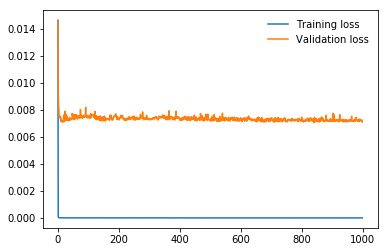

In [59]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# loss 0.24 -> 2800
# loss 0.14 -> 3300

In [61]:
test_x = torch.from_numpy(test_x.values).float().to(device)

In [65]:

with torch.no_grad():
    model.eval()
    output = model.forward(test_x)
    

output.shape
output = output.cpu().numpy()
#output_col = pd.DataFrame(test, columns = columns)

output = y_scaler.inverse_transform(output)


In [67]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = output
submission.to_csv('submission/DNN_result.csv', index=False)